In [24]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append('../.venv/lib/python3.9/site-packages/')
sys.path.append('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Custom code
from coordination.common.sparse_series import SparseSeries
from coordination.inference.vocalics import ContinuousCoordinationInferenceFromVocalics
from coordination.plot.coordination import plot_continuous_coordination, add_continuous_coordination_bar
from coordination.plot.vocalics import plot_vocalic_features
from coordination.synthetic.coordination_generator import ContinuousCoordinationGenerator, DiscreteCoordinationGenerator
from coordination.synthetic.vocalics_generator import VocalicsGeneratorForContinuousCoordination

In [26]:
# Constants
SEED = 0 # For reproducibility
OBSERVATION_DENSITY = 1 # Proportion of timesteps with observation
NUM_TIME_STEPS = 100
M = int(NUM_TIME_STEPS/2) # We assume coordination in the second half of the period is constant for now
NUM_FEATURES = 2

# Parameters of the distributions
MEAN_COORDINATION_PRIOR = 0; STD_COORDINATION_PRIOR = 0 # The process starts with no coordination
STD_COORDINATION_DRIFT = 0.1 # Coordination drifts little
MEAN_PRIOR_VOCALICS = np.zeros(NUM_FEATURES)
STD_PRIOR_VOCALICS = np.ones(NUM_FEATURES)
STD_COORDINATED_VOCALICS = np.ones(NUM_FEATURES)

## Syntetic Data

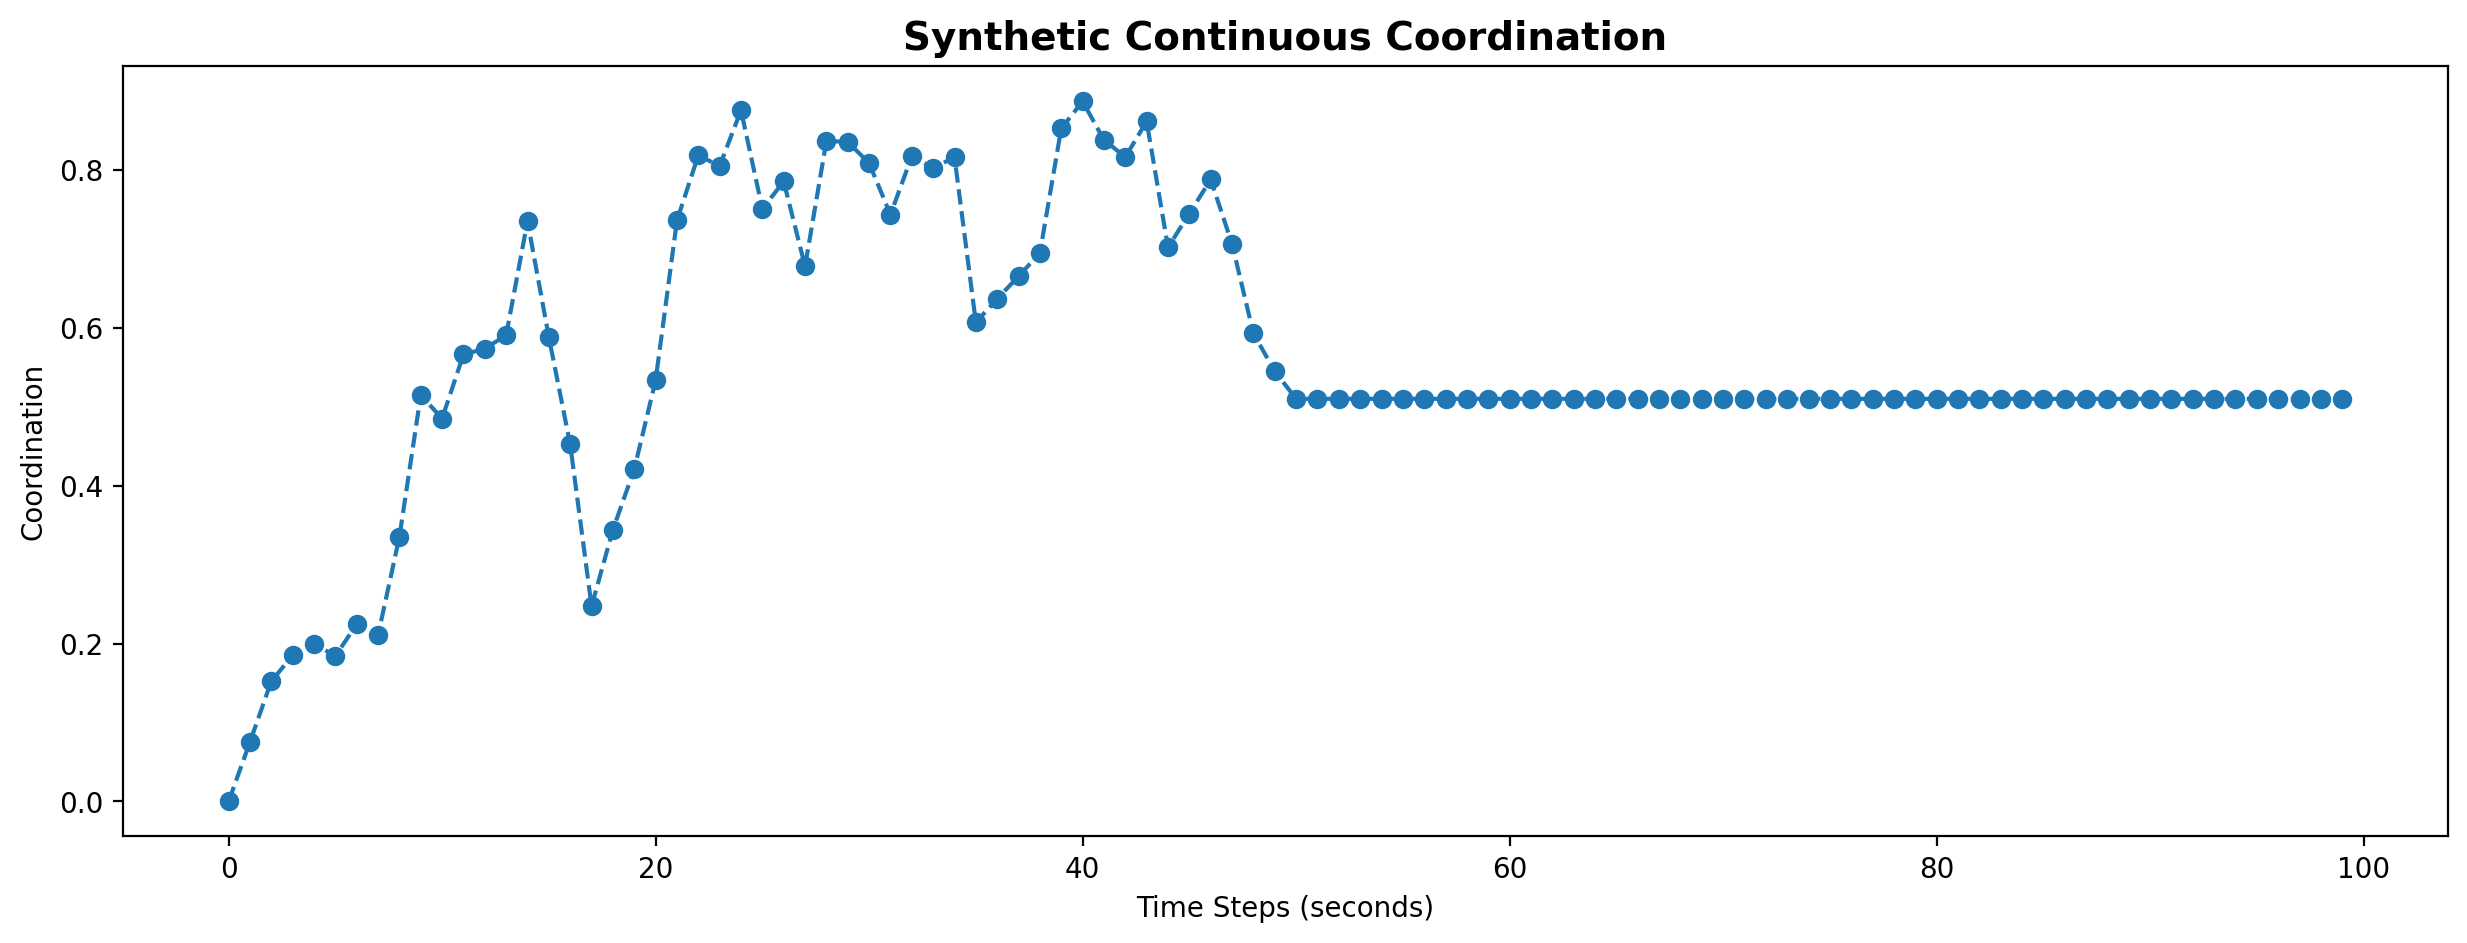

In [27]:
generator = ContinuousCoordinationGenerator(num_time_steps=NUM_TIME_STEPS, 
                                            prior_mean=MEAN_COORDINATION_PRIOR, 
                                            prior_std=STD_COORDINATION_PRIOR, 
                                            transition_std=STD_COORDINATION_DRIFT)
continuous_cs = generator.generate(SEED)
continuous_cs[M:] = continuous_cs[M]

fig = plt.figure(figsize=(15,5))
plot_continuous_coordination(ax=fig.gca(), 
                             coordination=continuous_cs, 
                             color="tab:blue", 
                             title="Synthetic Continuous Coordination",
                             xaxis_label="Time Steps (seconds)")

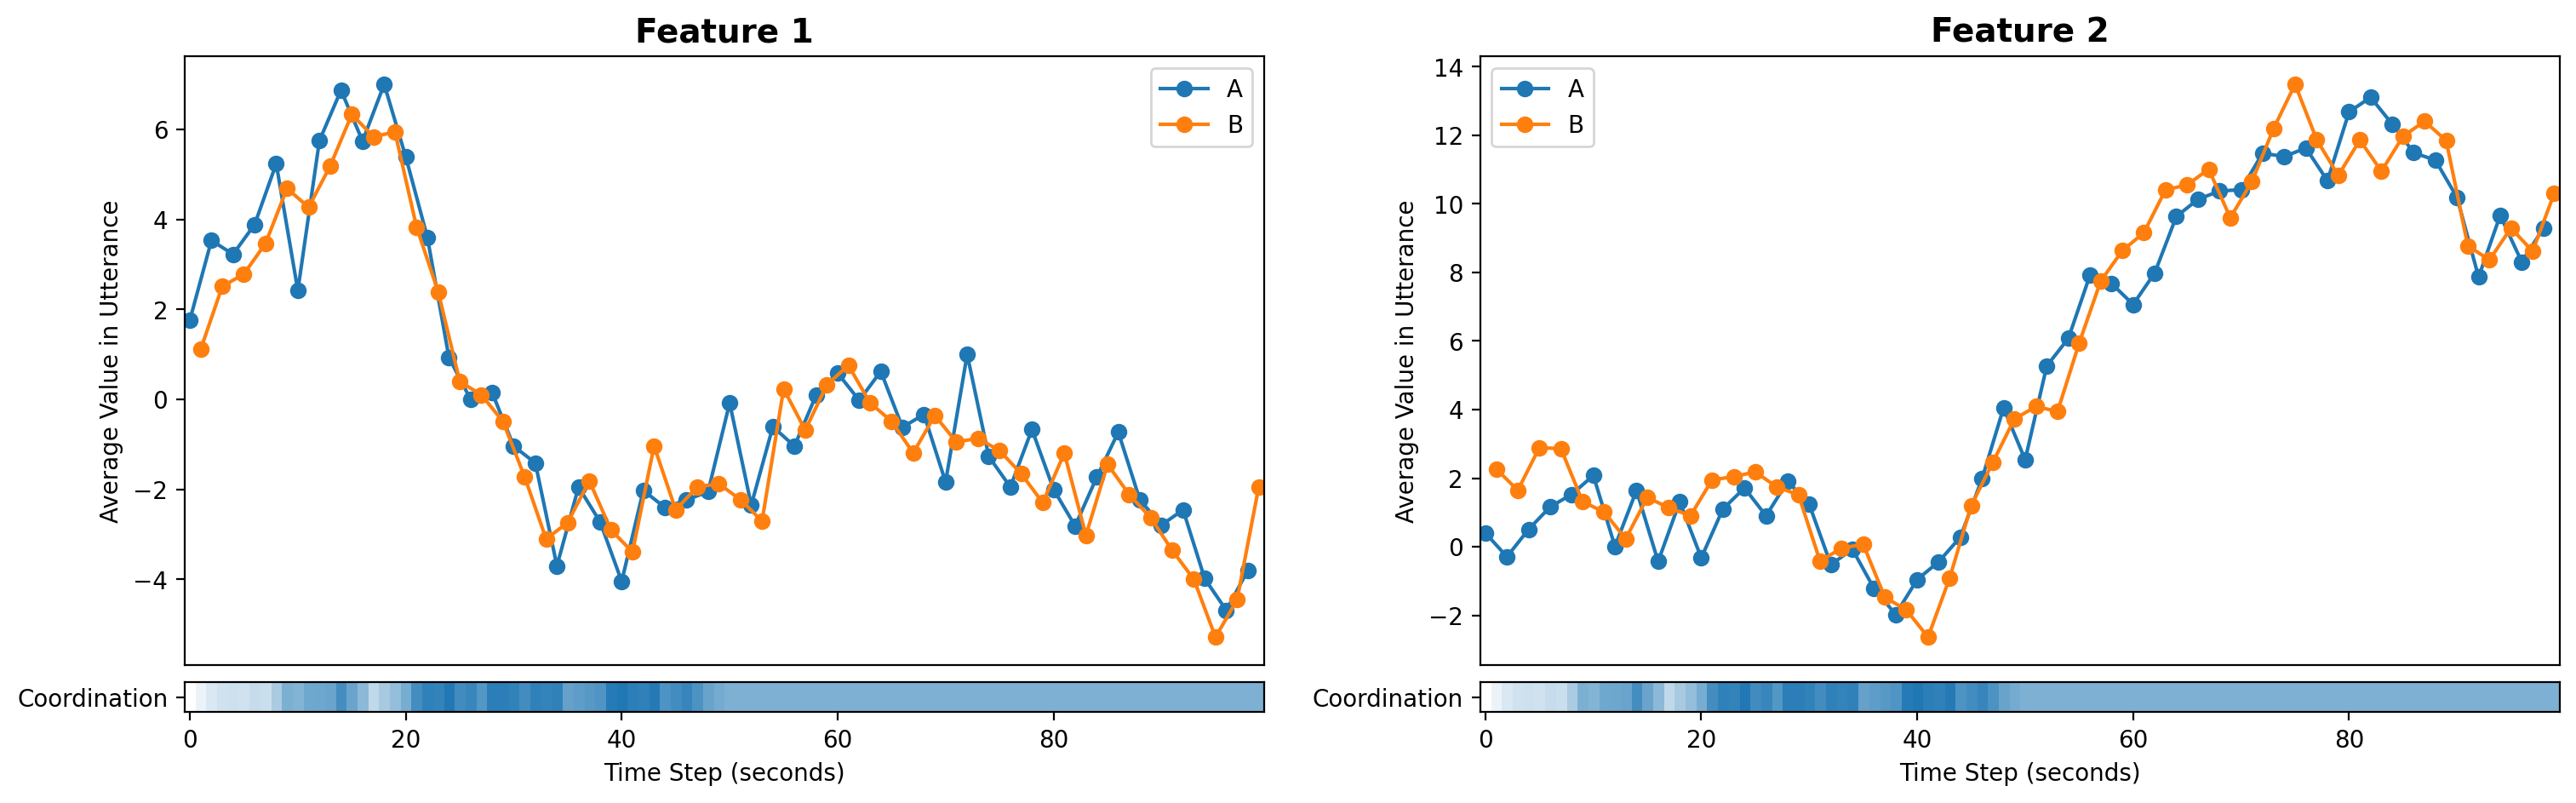

In [28]:
generator = VocalicsGeneratorForContinuousCoordination(coordination_series=continuous_cs,
                                                       num_vocalic_features=NUM_FEATURES,
                                                       time_scale_density=OBSERVATION_DENSITY,
                                                       mean_prior_vocalics=MEAN_PRIOR_VOCALICS,
                                                       std_prior_vocalics=STD_PRIOR_VOCALICS,
                                                       std_coordinated_vocalics=STD_COORDINATED_VOCALICS)
vocalic_series = generator.generate(SEED)

fig, axs = plt.subplots(1, 2, figsize=(18,5))
plot_vocalic_features(axs, vocalic_series, ["Feature 1", "Feature 2"], False)
add_continuous_coordination_bar(main_ax=axs[0],
                                coordination_series=[continuous_cs],
                                coordination_colors=["tab:blue"],
                                labels=["Coordination"])
add_continuous_coordination_bar(main_ax=axs[1],
                                coordination_series=[continuous_cs],
                                coordination_colors=["tab:blue"],
                                labels=["Coordination"])

## Inference

Based on the observed vocalic series component, we can infer the coordination at each time step. The joint distribution of coordination and vocalics components is

$
\begin{align}
p(C_{0:T}, A_{0:T}, B_{0:T}, f) = p(C_0)\prod^{T}_{t=1}p(C_t|C_{t-1})p(A_t|A_{t-1}, B_{t-1}, C_t, f)p(B_t|B_{t-1},A_{t-1},C_t, f)
\end{align}
$

Notice that for a certain $t$, $A_t$ and $B_t$ might not have been observed, which means we do not include their terms in the equation above, or they are replaced by 1 which has the same effect. Also, $B_{t-1}$ and $A_{t-1}$ refer to the last time values for the series were observed, thus that might not correspond to the actual $t-1$ time step. 

Since all the distributions are Gaussians, inference here can be performed exactly using Kalman filter and Rauch–Tung–Striebel smoother.

The formulas were adapted from https://jwmi.github.io/ASM/6-KalmanFilter.pdf for the univariate case and our specific model formulation.

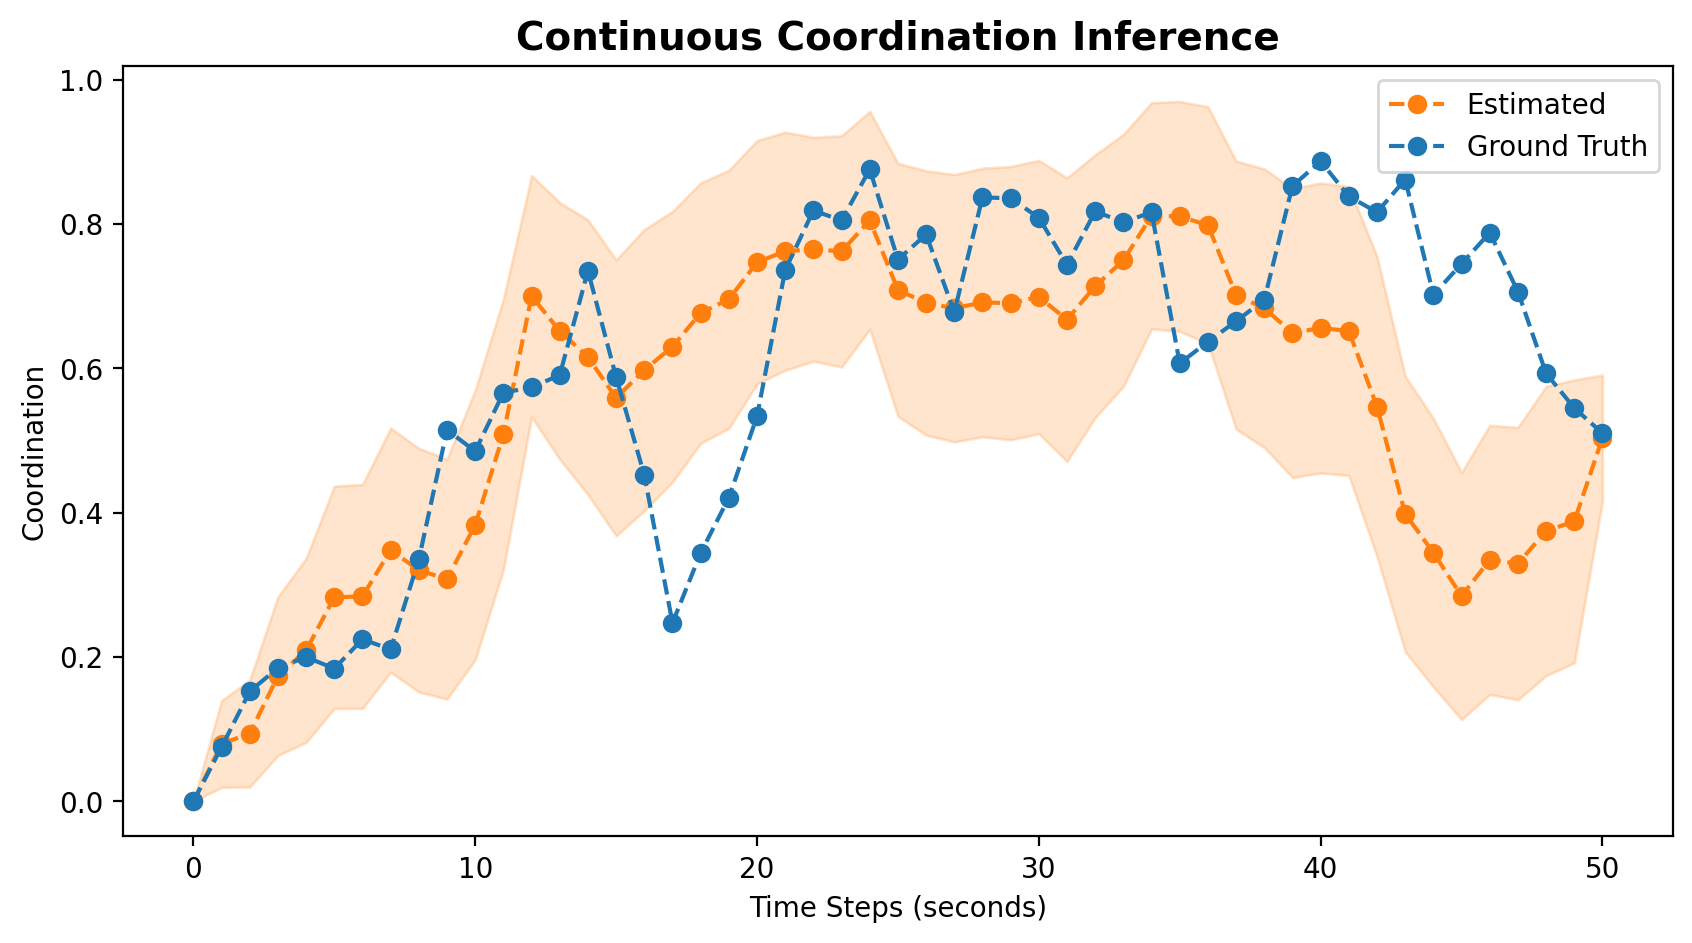

In [29]:
inference_engine = ContinuousCoordinationInferenceFromVocalics(vocalic_series=vocalic_series,
                                                               mean_prior_coordination=MEAN_COORDINATION_PRIOR,
                                                               std_prior_coordination=STD_COORDINATION_PRIOR, 
                                                               std_coordination_drifting=STD_COORDINATION_DRIFT,
                                                               mean_prior_vocalics=MEAN_PRIOR_VOCALICS,
                                                               std_prior_vocalics=STD_PRIOR_VOCALICS,
                                                               std_coordinated_vocalics=STD_COORDINATED_VOCALICS)

mean_cs, var_cs = inference_engine.estimate_means_and_variances()
fig = plt.figure(figsize=(10, 5))
plt.plot(range(M+1), mean_cs, marker="o", color="tab:orange", linestyle="--", label='Estimated')
plt.fill_between(range(M+1), mean_cs - np.sqrt(var_cs), mean_cs + np.sqrt(var_cs), color='tab:orange', alpha=0.2)
plt.plot(range(M+1), continuous_cs[0:M+1], marker="o", color="tab:blue", linestyle="--", label='Ground Truth')
plt.xlabel("Time Steps (seconds)")
plt.ylabel("Coordination")
plt.title("Continuous Coordination Inference", fontsize=14, weight="bold")
plt.legend()

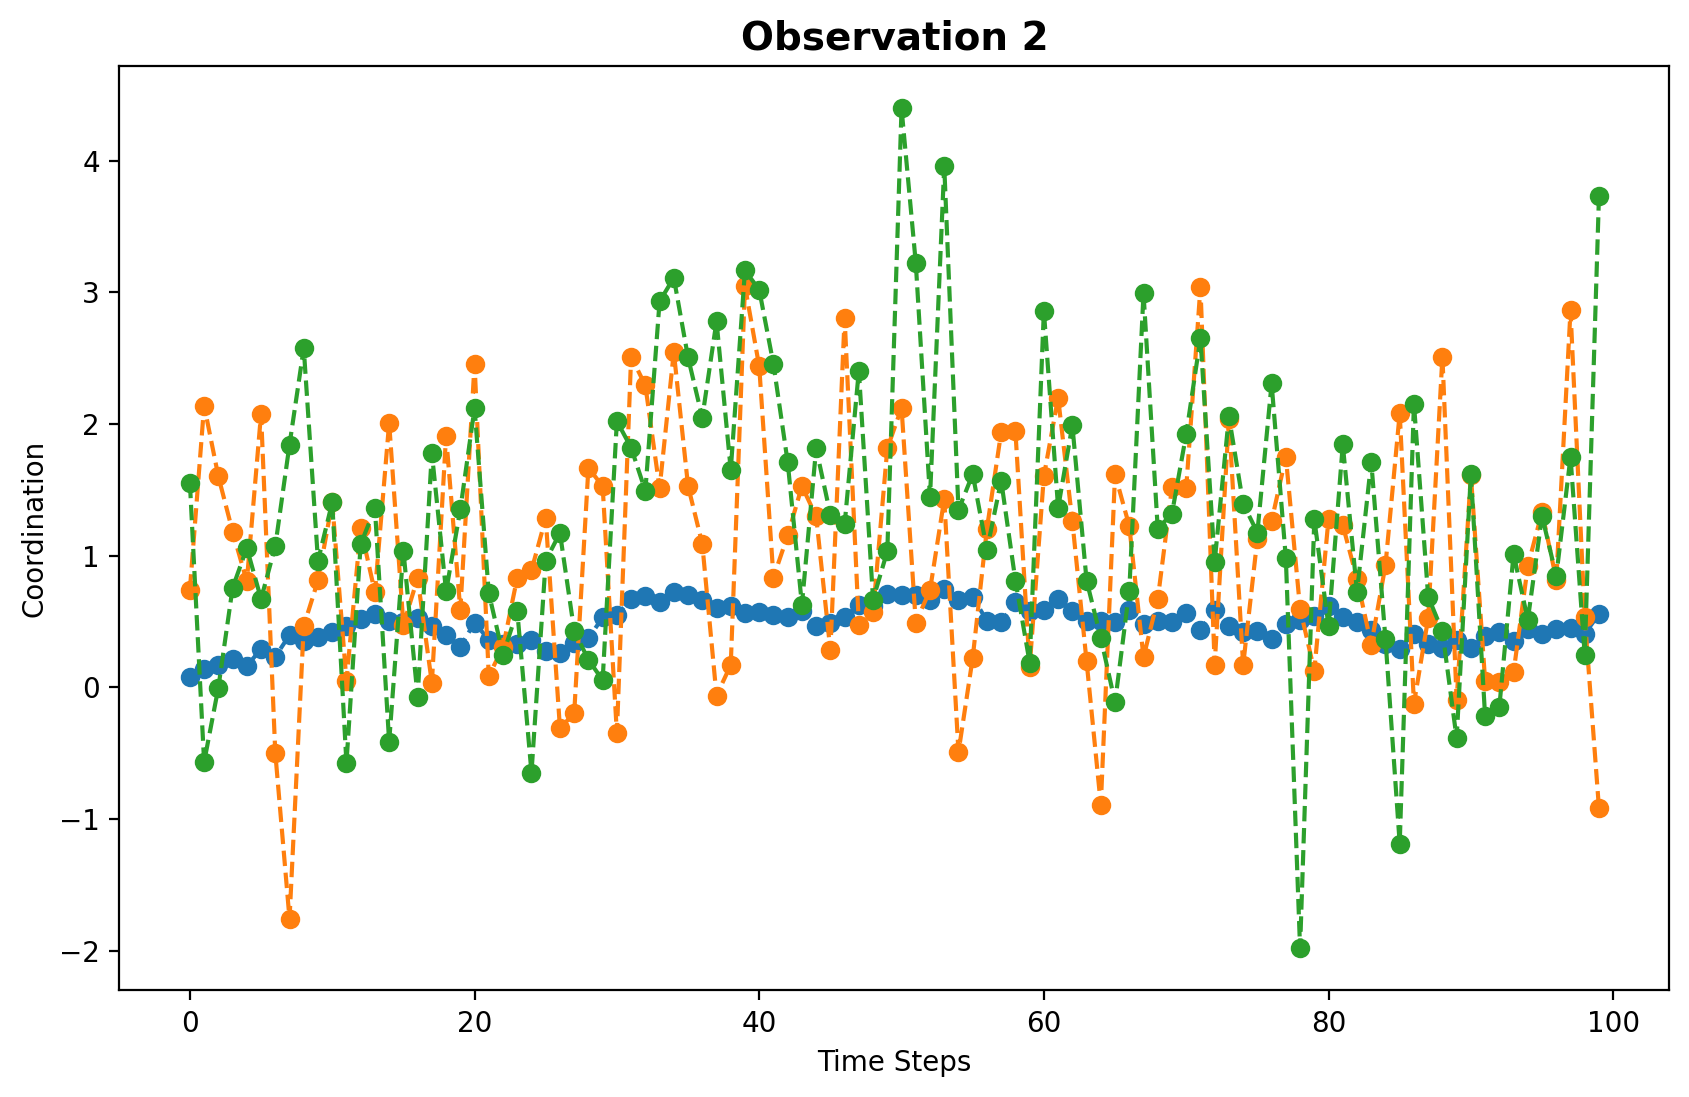

In [30]:
from scipy.stats import truncnorm, norm

np.random.seed(0)

T = 100
H = 2
H2 = 3
b = 0
b2 = 0
M0 = 0
V0 = 0.1
Q = 0.1
F = 1
R = 1
R2 = 1
cs = np.zeros(T)
obs = np.zeros(T)
obs2 = np.zeros(T)
for t in range(0, T):
    if t == 0:
        cs[t] = truncnorm.rvs(loc=M0, scale=V0, a=(0-M0)/np.sqrt(V0), b=(1-M0)/np.sqrt(V0))
#         cs[t] = norm.rvs(loc=M0, scale=V0)
        obs[t] = norm.rvs(loc=0, scale=R)
        obs2[t] = norm.rvs(loc=0, scale=R2)
    else:
        cs[t] = truncnorm.rvs(loc=F * cs[t-1], scale=Q, a=(0- F * cs[t-1])/np.sqrt(Q), b=(1-F * cs[t-1])/np.sqrt(Q))
#         cs[t] = norm.rvs(loc=F * cs[t-1], scale=Q)
        obs[t] = norm.rvs(loc=H * cs[t] + b, scale=R)
        obs2[t] = norm.rvs(loc=H2 * cs[t] + b2, scale=R2)
fig = plt.figure(figsize=(10,6))
plot_continuous_coordination(fig.gca(), cs, "tab:blue", "Coordination", "Time Steps")
plot_continuous_coordination(fig.gca(), obs, "tab:orange", "Observation", "Time Steps")
plot_continuous_coordination(fig.gca(), obs2, "tab:green", "Observation 2", "Time Steps")

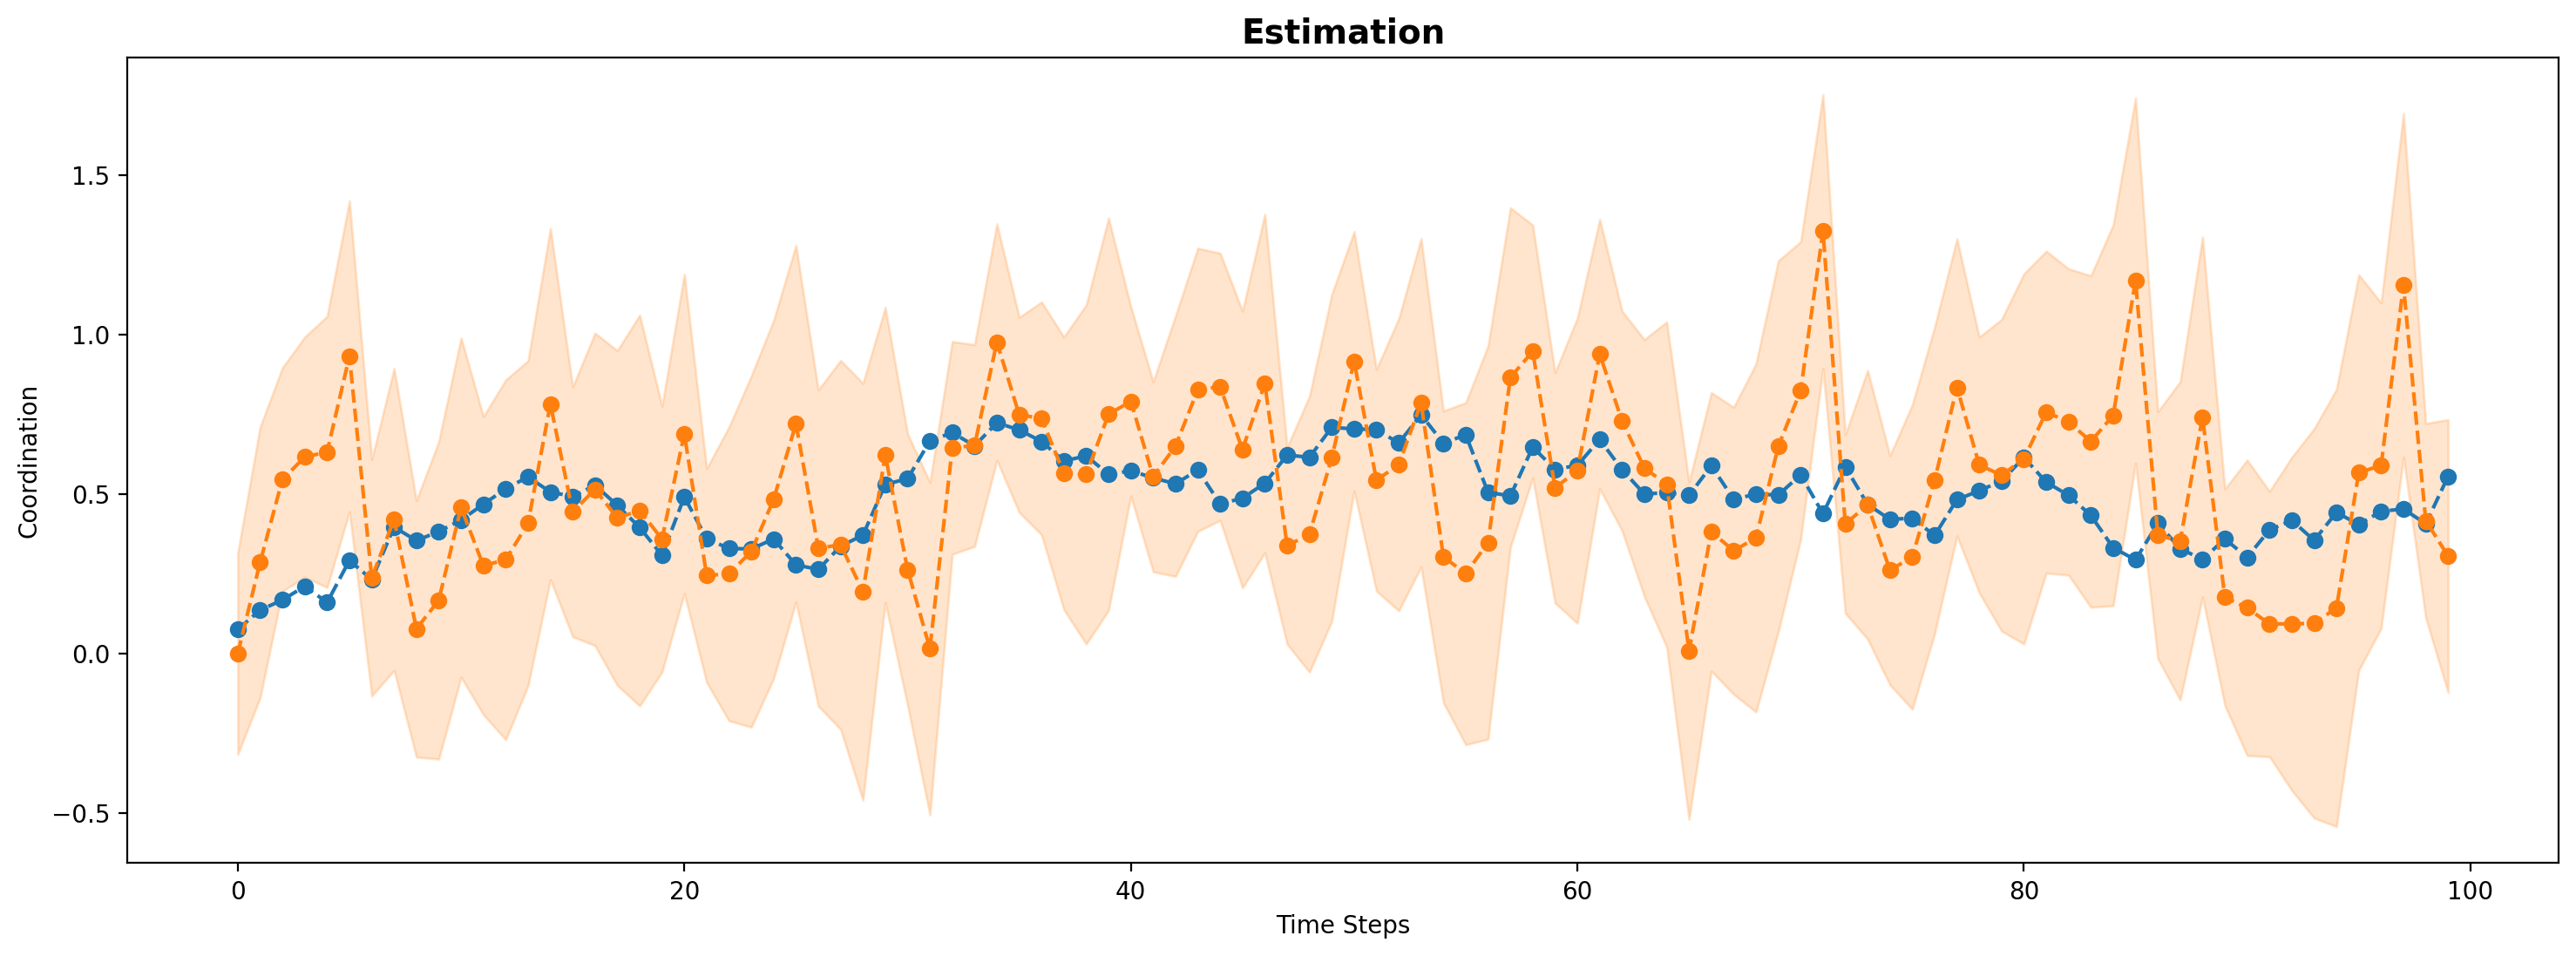

In [31]:
# K = (V0*H)/(H*V0*H + R)
# M = M0 + K*(obs[1] - H*M0 - b)
# V = (1-K*H)*V0
M = M0
V = V0
P = F*V*F + Q

params = np.zeros((2, T))
params[:, 0] = [M, V]

for t in range(1,T):  
    H = obs[t-1]
    K = (P*H)/(H*P*H + R)
    M = F*M + K*(obs[t] - H*(F*M - b))
    V = (1-K*H)*P
    P = F*V*F + Q
    
#     H2 = obs2[t-1]
#     K = (P*H2)/(H2*P*H2 + R2)
#     M = F*M + K*(obs2[t] - H2*(F*M - b2))
#     V = (1-K*H2)*P
#     P = F*V*F + Q
    
    params[:, t] = [M, V]

fig = plt.figure(figsize=(18,6))
plot_continuous_coordination(fig.gca(), cs, "tab:blue", "Coordination", "Time Steps")
plot_continuous_coordination(fig.gca(), params[0, :], "tab:orange", "Estimation", "Time Steps")
plt.fill_between(range(T), params[0, :] - np.sqrt(params[1, :]), params[0, :] + np.sqrt(params[1, :]), color='tab:orange', alpha=0.2)

True

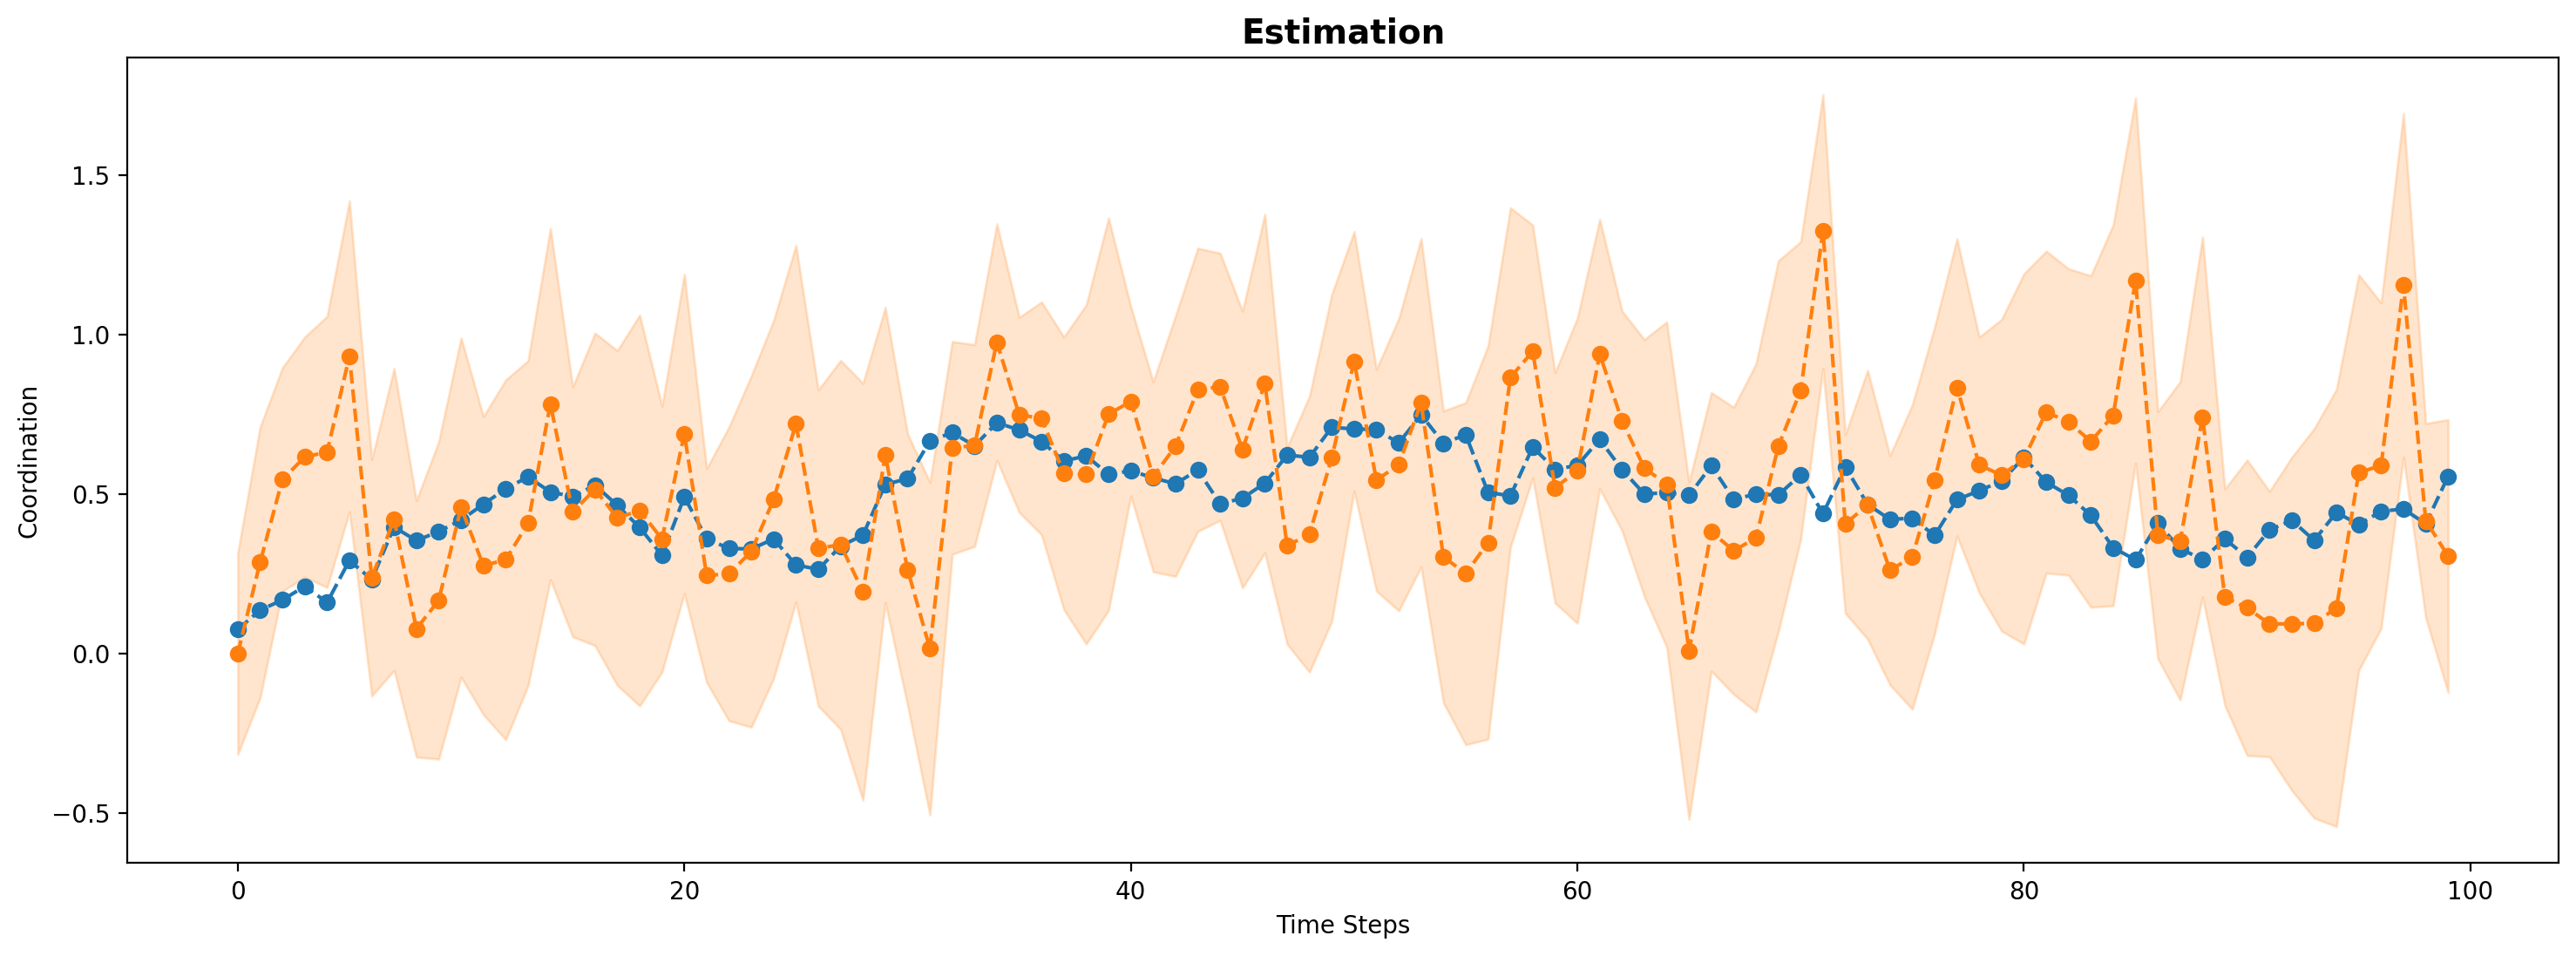

In [34]:
from coordination.inference.lds import apply_conditional_property, apply_marginal_property

params2 = np.zeros((2, T))
# params2[:, 0] = apply_conditional_property(obs[0], H, b, R, M0, V0)
params2[:, 0] = [M0, V0]

def mean_shift(mean, var):
    return mean - np.sqrt(std) * (norm.pdf(1) - norm.pdf(0)) / (norm.cdf(1) - norm.cdf(0))

def var_shift(mean, var):
    alpha = (0 - mean) / np.sqrt(var)
    beta = (1 - mean) / np.sqrt(var)
    return var * (1 - (beta*norm.pdf(beta) - alpha*norm.pdf(alpha)) / (norm.cdf(beta) - norm.cdf(alpha)))

for t in range(1,T):        
    mean, var = apply_marginal_property(F, 0, Q, *params2[:, t-1])
#     mean, var = apply_conditional_property(obs[t], H, b, R, mean, var)
#     params2[:, t] = apply_conditional_property(obs2[t], H2, b2, R2, mean, var)
    mean, var = apply_conditional_property(obs[t], obs[t-1], b, R, mean, var)
    params2[:, t] = [mean, var]

fig = plt.figure(figsize=(18,6))
plot_continuous_coordination(fig.gca(), cs, "tab:blue", "Coordination", "Time Steps")
plot_continuous_coordination(fig.gca(), params2[0, :], "tab:orange", "Estimation", "Time Steps")
plt.fill_between(range(T), params2[0, :] - np.sqrt(params2[1, :]), params2[0, :] + np.sqrt(params2[1, :]), color='tab:orange', alpha=0.2)

np.allclose(params, params2)